# Lab 2b: Model selection
## Dark matter
We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). The task is to classifying gamma rays, which consist of high-energy particles. When they hit our atmosphere, they produce chain reactions of other particles called 'showers'. However, similar showers are also produced by other particles (hadrons). We want to be able to detect which ones originate from gamma rays and which ones come from background radiation. To do this, the observed shower patterns are observed and converted into 10 numeric features. You need to detect whether these are gamma rays or background radiation. This is a key aspect of research into dark matter, which is believed to generate such gamma rays. If we can detect where they occur, we can build a map of the origins of gamma radiation, and locate where dark matter may occur in the observed universe. However, we'll first need to accurately detect these gamma rays first.

A quick visualization of the features is shown below. Note that this is not a time series, we just plot the instances in the order they occur in the dataset. The first 12500 or so are examples of signal (gamma), the final 6700 or so are background (hadrons).

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

In [2]:
# Download MAGIC Telescope data from OpenML. You can repeat this analysis with any other OpenML classification dataset.
magic = oml.datasets.get_dataset(1120)
X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array'); 
attribute_names = [f.name for i,f in magic.features.items()][:-1][1:]

/var/folders/76/dl3rv17s7xz76wgx74llyccm0000gn/T/ipykernel_63302/2616928666.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array');


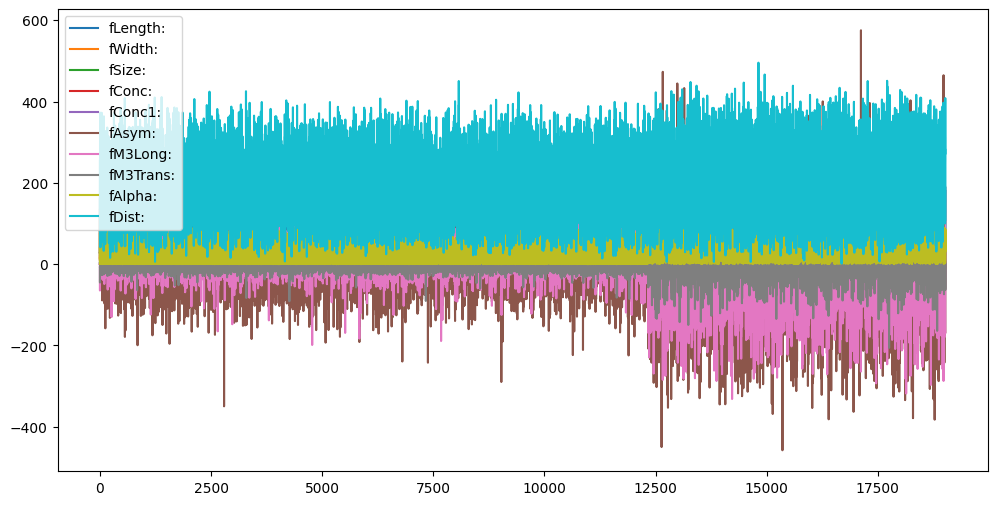

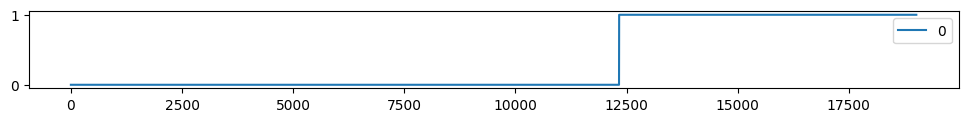

In [3]:
# Quick visualization of the features (top) and the target (bottom)
magic_df = pd.DataFrame(X, columns=attribute_names)
magic_df.plot(figsize=(12,6))
# Also plot the target: 1 = background, 0 = gamma
pd.DataFrame(y).plot(figsize=(12,1));

## Exercise 1: Metrics
Train and evaluate an SVM with RBF kernel (default hyperparameters) using a standard 25% holdout. Report the accuracy, precision, recall, F1 score, and area under the ROC curve (AUC).

Answer the following questions:
* How many of the detected gamma rays are actually real gamma rays?
* How many of all the gamma rays are we detecting?
* How many false positives and false negatives occur?

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a linear SVM
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

# Evaluate the model
scores = cross_validate(clf, X_train, y_train, cv=10, scoring=('accuracy', 'f1', 'roc_auc', 'precision', 'recall'))

print('Accuracy:', np.mean(scores['test_accuracy']))
print('Precision:', np.mean(scores['test_precision']))
print('Recall:', np.mean(scores['test_recall']))
print('F1:', np.mean(scores['test_f1']))
print('ROC AUC:', np.mean(scores['test_roc_auc']))

# Give the confusion matrix
y_pred = clf.predict(X_test)
cf = confusion_matrix(y_test, y_pred)

cf

Accuracy: 0.8208193318400591
Precision: 0.8719093363925641
Recall: 0.5763158103173786
F1: 0.6936056085772789
ROC AUC: 0.8693485505620663


array([[2955,  137],
       [ 690,  973]])

In [5]:
print(f'Number of detected gamma rays that are real gamma rays (True Positives): {cf[0,0]}')
print(f'Number of detected gamma rays (Total positives): {cf[0,0] + cf[1,0]}')
print(f'Number of false positives: {cf[0, 1]}')
print(f'Number of false negatives: {cf[1, 0]}')

Number of detected gamma rays that are real gamma rays (True Positives): 2955
Number of detected gamma rays (Total positives): 3645
Number of false positives: 137
Number of false negatives: 690


## Exercise 2: Preprocessing
SVMs require scaling to perform well. For now, use the following code to scale the data (we'll get back to this in the lab about preprocessing and pipelines). Repeat question 2 on the scaled data. Have the results improved? 

In [6]:
from sklearn.preprocessing import StandardScaler
# Important here is to fit the scaler on the training data alone
# Then, use it to scale both the training set and test set
# This assumes that you named your training set X_train. Adapt if needed.
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

In [7]:
# Train a linear SVM
clf = SVC(kernel='rbf')
clf.fit(Xs_train, y_train)

# Evaluate the model
scores = cross_validate(clf, Xs_train, y_train, cv=10, scoring=('accuracy', 'f1', 'roc_auc', 'precision', 'recall'))

print('Accuracy:', np.mean(scores['test_accuracy']))
print('Precision:', np.mean(scores['test_precision']))
print('Recall:', np.mean(scores['test_recall']))
print('F1:', np.mean(scores['test_f1']))
print('ROC AUC:', np.mean(scores['test_roc_auc']))

# Give the confusion matrix
y_pred = clf.predict(Xs_test)
cf = confusion_matrix(y_test, y_pred)

cf

Accuracy: 0.8676473854760571
Precision: 0.8925036421096977
Recall: 0.7098488748782208
F1: 0.7906391192486054
ROC AUC: 0.9173177810219106


array([[2959,  133],
       [ 488, 1175]])

## Exercise 3: Hyperparameter optimization
Use 50 iterations of random search to tune the $C$ and $gamma$ hyperparameters on the scaled training data. Vary both on a log scale (e.g. from 2^-12 to 2^12). Optimize on AUC and use 3 cross-validation (CV) folds for the inner CV to estimate performance. For the outer loop, just use the train-test split you used before (hence, no nested CV). Report the best hyperparameters and the corresponding AUC score. Is it better than the default? Finally, use them to evaluate the model on the held-out test set, for all 5 metrics we used before.

Extra challenge: plot the samples used by the random search ($C$ vs $gamma$)

Note: The reason we don't use a nested CV just yet is because we would need to rebuild the scaled training and test set multiple times. This is tedious, unless we use pipelines, which we'll cover in a future lab.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

param_grid = {
    'C': expon(scale=12),
    'gamma': expon(scale=12)
}

random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
random_search.fit(Xs_train, y_train)

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x103fbef80>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31febf700>},
                   random_state=42, scoring='roc_auc')

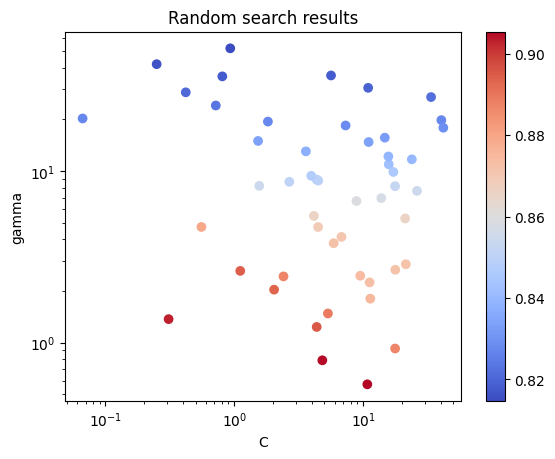

In [9]:
# plot values used in the search
plt.scatter(random_search.cv_results_['param_C'], random_search.cv_results_['param_gamma'], c=random_search.cv_results_['mean_test_score'], cmap=cm.coolwarm)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('gamma')
plt.title('Random search results')
plt.show()

In [10]:
scores = cross_validate(random_search.best_estimator_, Xs_train, y_train, cv=10, scoring=('accuracy', 'f1', 'roc_auc', 'precision', 'recall'), n_jobs=-1)

print('Accuracy:', np.mean(scores['test_accuracy']))
print('Precision:', np.mean(scores['test_precision']))
print('Recall:', np.mean(scores['test_recall']))
print('F1:', np.mean(scores['test_f1']))
print('ROC AUC:', np.mean(scores['test_roc_auc']))

Accuracy: 0.8641430889546523
Precision: 0.8557797252187755
Recall: 0.7393079768401543
F1: 0.7931163697548653
ROC AUC: 0.9095761459425095


In [11]:
# Evaluate the model on the test set
y_pred = random_search.best_estimator_.predict(Xs_test)
cf = confusion_matrix(y_test, y_pred)

cf

array([[2912,  180],
       [ 447, 1216]])

## Exercise 4: Threshold calibration
First, plot the Precision-Recall curve for the SVM using the default parameters on the scaled data. Then, calibrate the threshold to find a solution that yields better recall without sacrificing too much precision.

In [12]:
from sklearn.metrics import precision_recall_curve

clf = SVC(kernel='rbf', C=1.0, gamma=1.0)
clf.fit(Xs_train, y_train)

precision, recall, thresholds = precision_recall_curve(
    y_test, clf.decision_function(Xs_test))

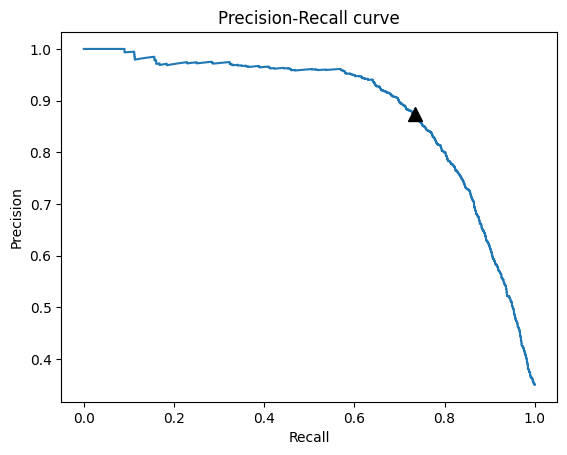

In [16]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')

# indicate the threshold in the plot
close_default = np.argmin(np.abs(thresholds))
plt.plot(recall[close_default], precision[close_default], '^', c='k', markersize=10)

plt.title('Precision-Recall curve')
plt.show()

## Exercise 5: Cost function
Assume that a false negative is twice as bad (costly) than a false positive. I.e. we would rather waste time checking gamma ray sources that are not real, than missing an interesting gamma ray source. Use ROC analysis to find the optimal threshold under this assumption.

Finally, let the model make predictions using the optimal threshold and report all 5 scores. Is recall better now? Did we lose a lot of precision?

In [17]:
# get the confusion matrix for the default threshold
y_pred = clf.predict(Xs_test)
cf = confusion_matrix(y_test, y_pred)

In [21]:
cost_fn = 2
cost_fp = 1

# for each threshold, calculate the cost
costs = []

for i, threshold in enumerate(thresholds):
    if i % 5 == 0:
        print(f'Processing threshold {i}/{len(thresholds)}')
    y_pred = clf.decision_function(Xs_test) > threshold
    cf = confusion_matrix(y_test, y_pred)
    costs.append(cost_fn * cf[1, 0] + cost_fp * cf[0, 1])

plt.plot(thresholds, costs)
plt.xlabel('Threshold')
plt.ylabel('Cost')
plt.title('Cost function')

Processing threshold 0/4747
Processing threshold 5/4747


KeyboardInterrupt: 